This is needed to reload modules without restarting the kernel

In [1]:
%load_ext autoreload
%autoreload 2

This is needed to add eda_tools from the directories above

In [2]:
import os
os.sys.path.append('../../')

In [3]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [4]:
import mplhep as hep
hep.set_style('ATLAS')

In [5]:
from hh4b_utils.nnt_tools import load_nnt

In [6]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [7]:
from sklearn.metrics import auc

In [249]:
from sklearn import tree

# Classifier MVA

Lets give the good old classifier a college try

In [8]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           125G         54G         56G         45M         15G         69G
Swap:           15G         13G        2.8G


In [9]:
!ls -lh /mnt/storage/lborgna/NNT/MDR_VEC/mc

total 6.3G
-rw-r--r-- 1 lborgna users 1.9G Apr 16 15:12 allhad_mc16a_merge.root
drwxr-xr-x 5 lborgna users 4.0K Apr 19 11:21 DEC20_prod
-rw------- 1 lborgna users  80M Apr 28 17:44 mc16a_2b_shiftKR_lshi.root
-rw-r--r-- 1 lborgna users  87M Apr 29 01:04 mc16d_2b_shiftKR_lshi.root
-rw-r--r-- 1 lborgna users 147M Apr 29 01:04 mc16e_2b_shiftKR_lshi.root
-rw-r--r-- 1 lborgna users 140M Feb 25 01:22 NanoNTuple.root
-rw-r--r-- 1 lborgna users 3.2G Apr 16 15:16 semilep_mc16a_merge.root
-rw-r--r-- 1 lborgna users  81M Apr 20 18:04 SMNR_600043_2B_SRshift_mc16a_new.root
-rw-r--r-- 1 lborgna users  17M Apr  5 17:28 SMNR_600043_mc16a_2B_SRshift.root
-rw-r--r-- 1 lborgna users  73M Feb 25 02:33 SMNR_600043_mc16a_b.root
-rw-r--r-- 1 lborgna users  73M Mar  2 23:57 SMNR_600043_mc16a.root
-rw-r--r-- 1 lborgna users  25M Apr  5 16:58 SMNR_600043_mc16a_SRshift.root
-rw-r--r-- 1 lborgna users  17M Feb 23 23:28 SMNR_600043_mc16a_two_buckets.root
-rw-r--r-- 1 lborgna users  19M Apr  5 17:28 SMNR_600043_mc16

In [10]:
file_path = "/mnt/storage/lborgna/NNT/MDR_VEC/mc/mc16a_2b_shiftKR_lshi.root"

In [11]:
f = uproot.open(file_path)

In [12]:
df = load_nnt(file_path, trees=['sig'])

100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


In [37]:
features = ['Xhh','dEta_hh']

In [13]:
from hh4b_utils.nnt_tools import xhh

In [14]:
df['Xhh'] = xhh(df.m_h1, df.m_h2, m_h1_center=124, m_h2_center=117)

In [16]:
!ls -lh /mnt/storage/lborgna/NNT/MDR_VEC/data/data_CRVRSR_2B_SRshift_16_NN_100_bootstraps.root

-rw-r--r-- 1 lborgna users 509M Apr 22 04:01 /mnt/storage/lborgna/NNT/MDR_VEC/data/data_CRVRSR_2B_SRshift_16_NN_100_bootstraps.root


In [17]:
data = load_nnt('/mnt/storage/lborgna/NNT/MDR_VEC/data/data_CRVRSR_2B_SRshift_16_NN_100_bootstraps.root', trees=['sig'])

100%|██████████| 141/141 [00:26<00:00,  5.30it/s]


In [18]:
data = data[~data['pass_vbf_sel']].reset_index(drop=True)

In [19]:
df = df[~df['pass_vbf_sel']].reset_index(drop=True)

In [20]:
from hh4b_utils.nnt_tools import get_mu,w_col

In [21]:
f = uproot.open('/mnt/storage/lborgna/NNT/MDR_VEC/data/data_CRVRSR_2B_SRshift_16_NN_100_bootstraps.root')

In [22]:
norm = get_mu(f)

In [23]:
data['Xhh'] = xhh(data['m_h1'], data['m_h2'], m_h1_center=124, m_h2_center=117)

In [24]:
signal_df = df.loc[df['ntag']>=4].reset_index(drop=True)

In [25]:
signal_df.kinematic_region.value_counts()

0    21617
Name: kinematic_region, dtype: int64

In [26]:
signal_df['sample_weight'] = signal_df['mc_sf']
signal_df['sample_weight2'] = 1

In [27]:
bkg_df = data.loc[data['ntag']==2].reset_index(drop=True)

In [28]:
bkg_df['NN_weights'] = norm * bkg_df['NN_d24_weight_bstrap_med_16']

In [29]:
bkg_df['sample_weight'] = bkg_df['NN_weights']
bkg_df['sample_weight2'] = bkg_df['NN_weights']

In [30]:
bkg_df['class'] = 0

In [31]:
signal_df['class'] = 1

In [32]:
df_data = pd.concat([signal_df, bkg_df], ignore_index=True)

# Classifier

In [34]:
from xgboost import XGBClassifier

In [35]:
from sklearn.model_selection import train_test_split

In [38]:
X = df_data[features]
y = df_data['class']

In [43]:
Nbkg = df_data.loc[df_data['class']==0,'sample_weight2'].sum()
Nsig = df_data.loc[df_data['class']==1, 'sample_weight2'].sum()
R=Nbkg/Nsig
df_data['sample_weight3'] = df_data['sample_weight2']
df_data.loc[df_data['class']==1, 'sample_weight3'] = R

In [44]:
X_train, X_test, y_train, y_test,idx_train,idx_test = train_test_split(X, y, list(X.index), test_size=0.4)

In [45]:
train_weights = df_data['sample_weight3'][idx_train].values
test_weights = df_data['sample_weight3'][idx_test].values
model2D = XGBClassifier(verbosity = 1)
model2D.fit(X_train, y_train, sample_weight=train_weights)
pred2D = model2D.predict_proba(X_test)

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:44:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [265]:
model2D.save_model('XGB_16_2D.model')

Text(0.0, 1.0, 'Classifier 2D with NN weights \n(no mc_sf weights)$')

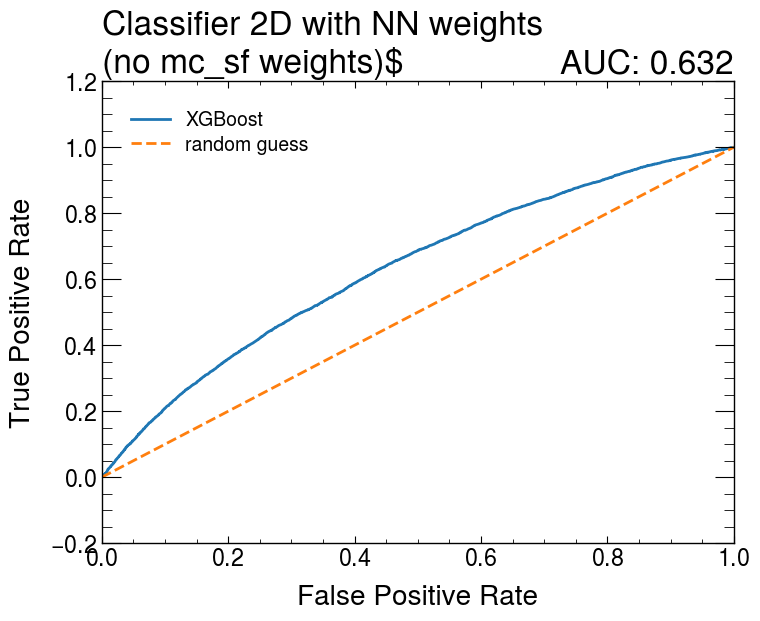

In [46]:
pred_positive = pred2D[:,1]
pred_negative = pred2D[:,0]
auc = roc_auc_score(y_test, pred_positive, sample_weight=test_weights)
fpr, tpr, _ = roc_curve(y_test, pred_positive, sample_weight=test_weights)
x_fpr = np.linspace(0, 1, 50)
y_tpr = np.linspace(0, 1, 50)
plt.plot(fpr, tpr, ls='-', label = 'XGBoost')
plt.plot(x_fpr, y_tpr, ls='--',label = 'random guess')
plt.legend()
plt.title('AUC: {:.3f}'.format(auc), loc='right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier 2D with NN weights \n(no mc_sf weights)$', loc='left')

In [47]:
sm_hh_prob = pred2D[:,1][y_test==1]
data_prob = pred2D[:,1][y_test==0]
h1, be,_ = plt.hist(sm_hh_prob, bins = 10, histtype='step',label='MC SM HH (probability = positive)', density= True)
h2,_,_ = plt.hist(data_prob, bins = be, histtype='step', label = 'data 2b (probability = negative)', density = True)
plt.legend()
plt.xlabel('predict proba', fontsize=18)
plt.ylabel('arb.units', fontsize = 18)
plt.title('XGBoost probability score', fontsize=18)

Text(0.5, 1.0, 'XGBoost probability score')

In [137]:
from hh4b_utils.plot_tools import hist2d,hist2d_ratio

In [51]:
help(hist2d)

Help on function hist2d in module hh4b_utils.plot_tools:

hist2d(x, y, **kwargs)
    plots a 2d histogram of feature x and y.
    plots their corresponding 1D projections (disable with "axis_hist_on = False")



In [52]:
df_data

run_number  event_number  pass_vbf_sel     mc_sf  trig_sf  \
0           307732        285153         False  0.000018      1.0   
1           307354        286651         False -0.000013      1.0   
2           310468        285723         False -0.000010      1.0   
3           304198        286574         False  0.000014      1.0   
4           304128        286945         False  0.000017      1.0   
...            ...           ...           ...       ...      ...   
415519      310809    3067103461         False  1.000000      1.0   
415520      310809    2063588288         False  1.000000      1.0   
415521      310809    1313567219         False  1.000000      1.0   
415522      310809    1313868051         False  1.000000      1.0   
415523      310809    1919891579         False  1.000000      1.0   

        jet_trig_sfs      truth_mhh  ntag  njets  kinematic_region  ...  \
0                1.0  539469.686412     4      4                 0  ...   
1                1.0  520006.020530     4      4                 0  ...   
2                1.0  612553.782663     4      5                 0  ...   
3                1.0  549449.184280     4      4                 0  ...   
4                1.0  450522.895701     4      5                 0  ...   
...              ...            ...   ...    ...               ...  ...   
415519           1.0       0.000000     2      4                 0  ...   
415520           1.0       0.000000     2      5                 0  ...   
415521           1.0       0.000000     2      4                 0  ...   
415522           1.0       0.000000     2      4                 0  ...   
415523           1.0       0.000000     2      5                 0  ...   

        NN_d24_weight_bstrap_med_16  NN_d24_weight_bstrap_perc_25_16  \
0                               NaN                              NaN   
1                               NaN                              NaN   
2                               NaN                              NaN   
3                               NaN                              NaN   
4                               NaN                              NaN   
...                             ...                              ...   
415519                     0.003736                         0.003118   
415520                     0.012392                         0.009065   
415521                     0.002782                         0.002027   
415522                     0.003958                         0.003282   
415523                     0.021107                         0.017891   

        NN_d24_weight_bstrap_perc_75_16  NN_d24_weight_bstrap_IQR_16  \
0                                   NaN                          NaN   
1                                   NaN                          NaN   
2                                   NaN                          NaN   
3                                   NaN                          NaN   
4                                   NaN                          NaN   
...                                 ...                          ...   
415519                         0.004332                     0.001215   
415520                         0.016190                     0.007125   
415521                         0.003381                     0.001354   
415522                         0.005257                     0.001974   
415523                         0.025305                     0.007414   

        NN_d24_weight_VRderiv_bstrap_med_16  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   
...                                     ...   
415519                             0.004319   
415520                             0.009718   
415521                             0.001726   
415522                             0.002434   
415523                         

In [53]:
pred = model2D.predict_proba(df_data[features])

In [55]:
df_data['pred_sig'] = pred[:,1]
df_data['pred_neg'] = pred[:,0]

In [63]:
_ = hist2d(
    df_data.m_hh.values,
    df_data["pred_sig"].values,
    xrange=(200, 800),
    yrange=(0, 1),
    xlabel="m_hh",
    ylabel="probability of signal",
    title='prediction probability'
)

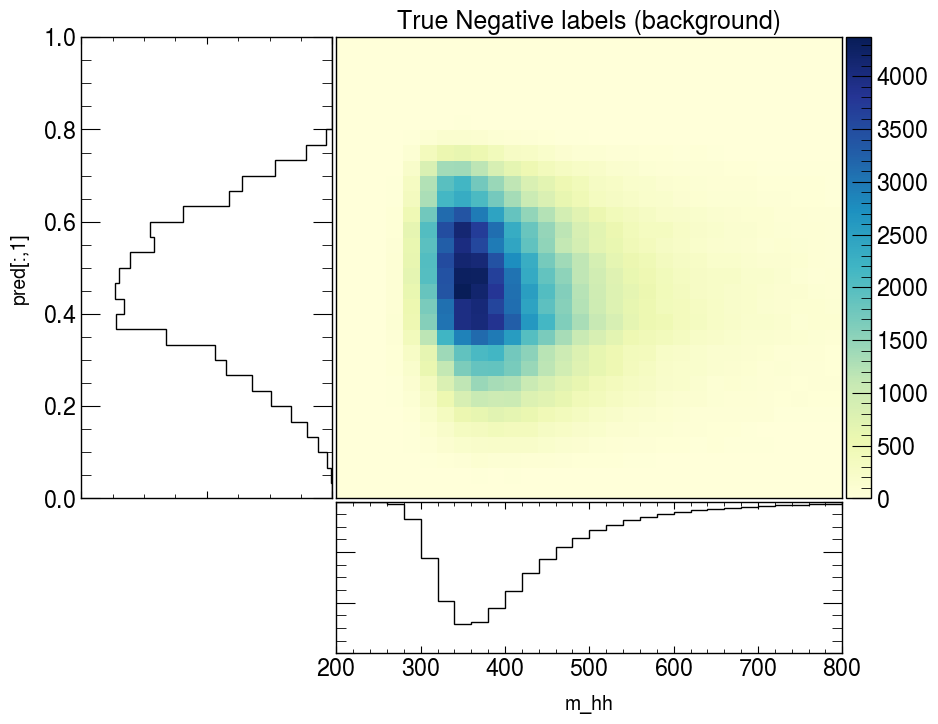

In [64]:
_ = hist2d(
    df_data.loc[df_data["class"] == 0, "m_hh"].values,
    df_data.loc[df_data["class"] == 0, "pred_sig"].values,
    xrange=(200, 800),
    yrange=(0, 1),
    xlabel="m_hh",
    ylabel="pred[:,1]",
    title='True Negative labels (background)'
)

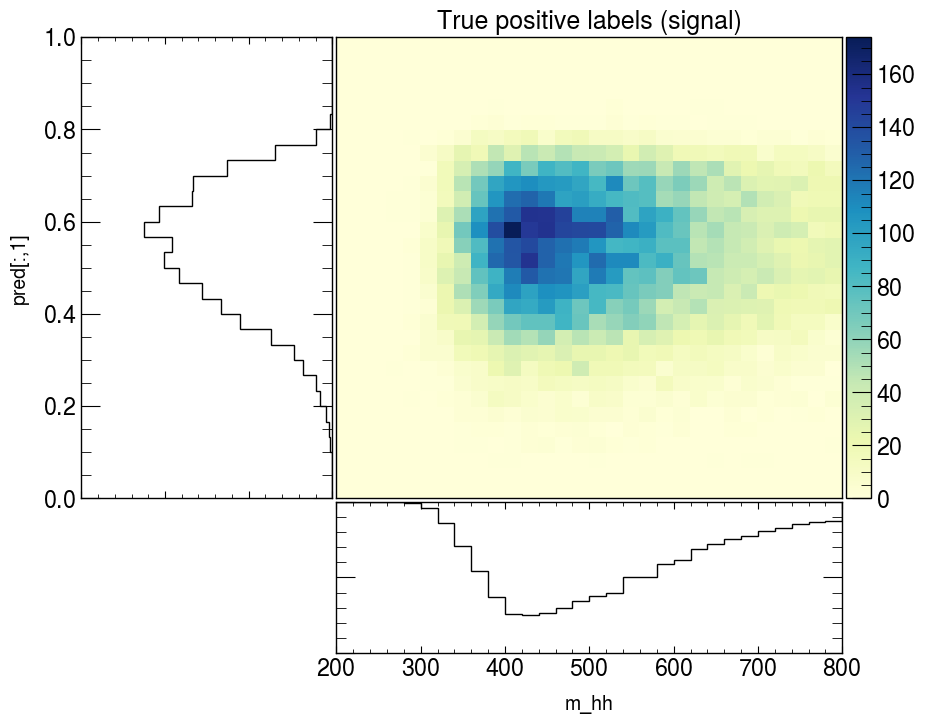

In [65]:
_ = hist2d(
    df_data.loc[df_data["class"] == 1, "m_hh"].values,
    df_data.loc[df_data["class"] == 1, "pred_sig"].values,
    xrange=(200, 800),
    yrange=(0, 1),
    xlabel="m_hh",
    ylabel="pred[:,1]",
    title="True positive labels (signal)"
)

# Probability contour lines

In [71]:
df_data['dEta_hh'].describe([0.01,0.99])

count    415524.000000
mean          0.724087
std           0.430382
min           0.000001
1%            0.013704
50%           0.711696
99%           1.482840
max           1.499998
Name: dEta_hh, dtype: float64

In [95]:
df_data['dEta_hh'].sample(n=3)

130944    0.857732
257714    0.739035
195783    0.073049
Name: dEta_hh, dtype: float32

In [108]:
x1 = np.linspace(0, 1.6, 1000)
x2 = np.linspace(0, 1.5, 1000)

In [96]:
idx =df_data.sample(n=1000).index

In [99]:
x1 = df_data['Xhh'][idx]
x2 = df_data['dEta_hh'][idx]

In [109]:
X1, X2 = np.meshgrid(x1,x2)

In [110]:
xx = np.vstack([X1.reshape(X1.size), X2.reshape(X2.size)]).T

array([[0.       , 0.0016016, 0.0032032, ..., 1.5967968, 1.5983984,
        1.6      ],
       [0.       , 0.0016016, 0.0032032, ..., 1.5967968, 1.5983984,
        1.6      ],
       [0.       , 0.0016016, 0.0032032, ..., 1.5967968, 1.5983984,
        1.6      ],
       ...,
       [0.       , 0.0016016, 0.0032032, ..., 1.5967968, 1.5983984,
        1.6      ],
       [0.       , 0.0016016, 0.0032032, ..., 1.5967968, 1.5983984,
        1.6      ],
       [0.       , 0.0016016, 0.0032032, ..., 1.5967968, 1.5983984,
        1.6      ]])

In [122]:
y_prob = model2D.predict_proba(xx)[:,1]

In [123]:
y_prob = y_prob.reshape((1000,1000))

In [124]:
X1.shape

(1000, 1000)

In [125]:
X2.shape

(1000, 1000)

In [115]:
y_prob.shape

(1000, 1000)

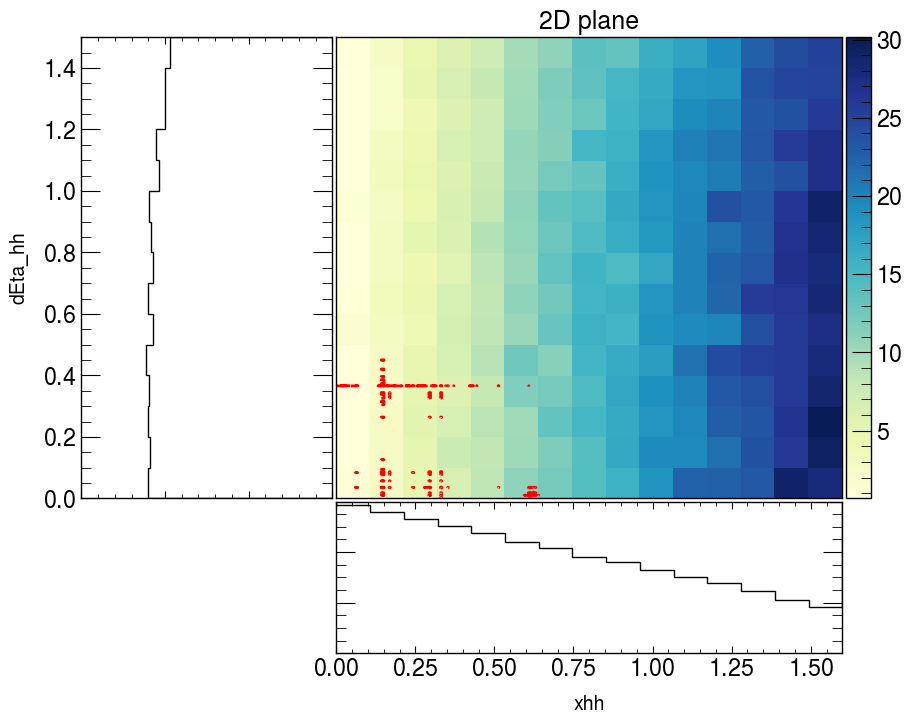

In [141]:
h_bkg = hist2d(
    df_data.loc[df_data['class']==0,"Xhh"].values,
    df_data.loc[df_data['class']==0,"dEta_hh"].values,
    xrange=(0, 1.6),
    yrange=(0, 1.5),
    bins=(15,15),
    xlabel="xhh",
    ylabel="dEta_hh",
    weights=df_data.loc[df_data['class']==0,'NN_weights'].values
)
cs = h_bkg['main_ax'].contour(X1, X2, y_prob, [0.80], colors='red',linestyles='--')

In [142]:
h_sig = hist2d(
    df_data.loc[df_data['class']==1,"Xhh"].values,
    df_data.loc[df_data['class']==1,"dEta_hh"].values,
    xrange=(0, 1.6),
    yrange=(0, 1.5),
    bins=(15,15),
    xlabel="xhh",
    ylabel="dEta_hh",
    weights=df_data.loc[df_data['class']==1,'mc_sf'].values
)
cs = h_sig['main_ax'].contour(X1, X2, y_prob, [0.80], colors='red',linestyles='--')

In [219]:
R = h_sig['h'] / np.sqrt(h_bkg['h'])
soverb = h_sig['h'] / h_bkg['h']
xedges=h_sig['xbins']
yedges=h_bkg['ybins']

In [156]:
X=df_data[['Xhh','dEta_hh']].values

# define bounds of the domain
min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

In [158]:
xx, yy = np.meshgrid(x1grid, x2grid)

In [159]:
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

In [161]:
grid = np.hstack((r1,r2))


In [175]:
yhat = model2D.predict_proba(grid)
# keep just the probabilities for class 0
yhatn = yhat[:, 0]
yhatp = yhat[:,1]

In [176]:
zz = yhatn.reshape(xx.shape)
zzp = yhatp.reshape(xx.shape)


In [174]:
f, ax = plt.subplots()
cs = ax.contour(xx, yy, zz,cmap='RdBu')
_=hist2d_ratio(
R,
ax=ax,
xedges=xedges,
yedges=yedges,xlabel='Xhh',ylabel='dEta_hh',colorbar=True)

# cs = ax.contour(X1, X2, y_prob, [0.6,0.75], colors ='green')
ax.set_xlim(0,1.6)
ax.set_ylim(0,1.5)

(0.0, 1.5)

In [212]:
help(hist2d_ratio)

Help on function hist2d_ratio in module hh4b_utils.plot_tools:

hist2d_ratio(R, ax=None, colorbar=False, cmap='YlGnBu', vmin=None, vmax=None, colorbarlabel:str='Ratio', xedges:tuple=(0, 1), yedges:tuple=(0, 1), xlabel:str='X', ylabel:str='Y') -> dict



/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: linewidths is ignored by contourf
  


Text(0.5, 1.0, '2D Classifier Decision Boundaries')

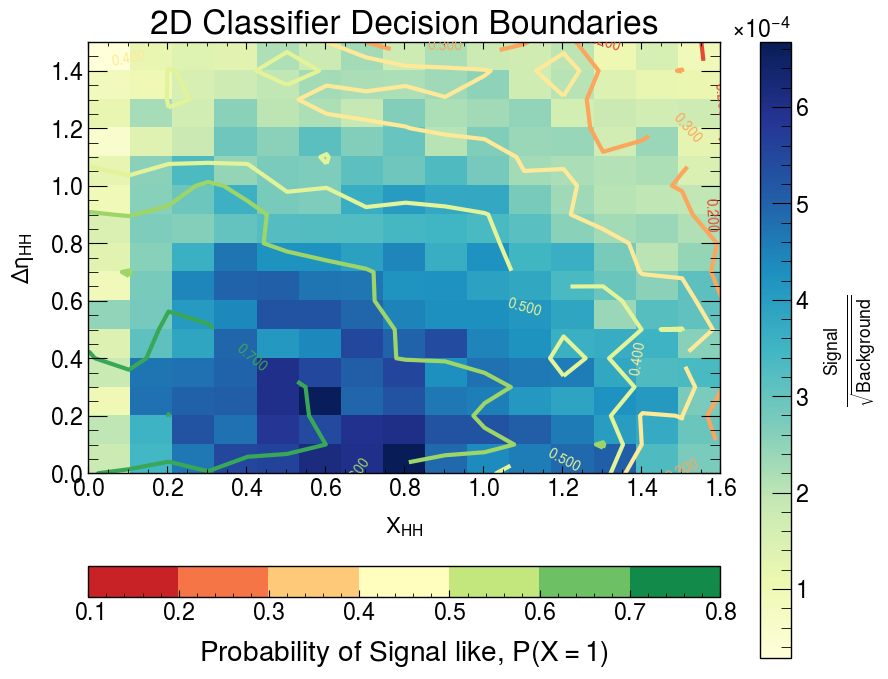

In [218]:
f, ax = plt.subplots(figsize=(10,8))
cs = ax.contourf(xx, yy, zzp, cmap="RdYlGn", linewidths=3, zorder=0)
_ = hist2d_ratio(
    R,
    ax=ax,
    xedges=xedges,
    yedges=yedges,
    xlabel=r"$X_{HH}$",
    ylabel=r"$\Delta\eta_{HH}$",
    colorbar=True,
    colorbarlabel=r'$\frac{Signal}{\sqrt{Background}}$'
)
cont = ax.contour(xx, yy, zzp, cmap="RdYlGn", linewidths=3)
ax.clabel(cont, inline=True, fontsize=10)
cbar = plt.colorbar(cs,orientation='horizontal')
cbar.set_label('Probability of Signal like, $P(X=1)$')
# plt.colorbar(cs, cax=ax)
# cs = ax.contour(X1, X2, y_prob, [0.6,0.75], colors ='green')
ax.set_xlim(0, 1.6)
ax.set_ylim(0, 1.5)
ax.set_title('2D Classifier Decision Boundaries')


/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: linewidths is ignored by contourf
  


Text(0.5, 1.0, '2D Classifier Decision Boundaries')

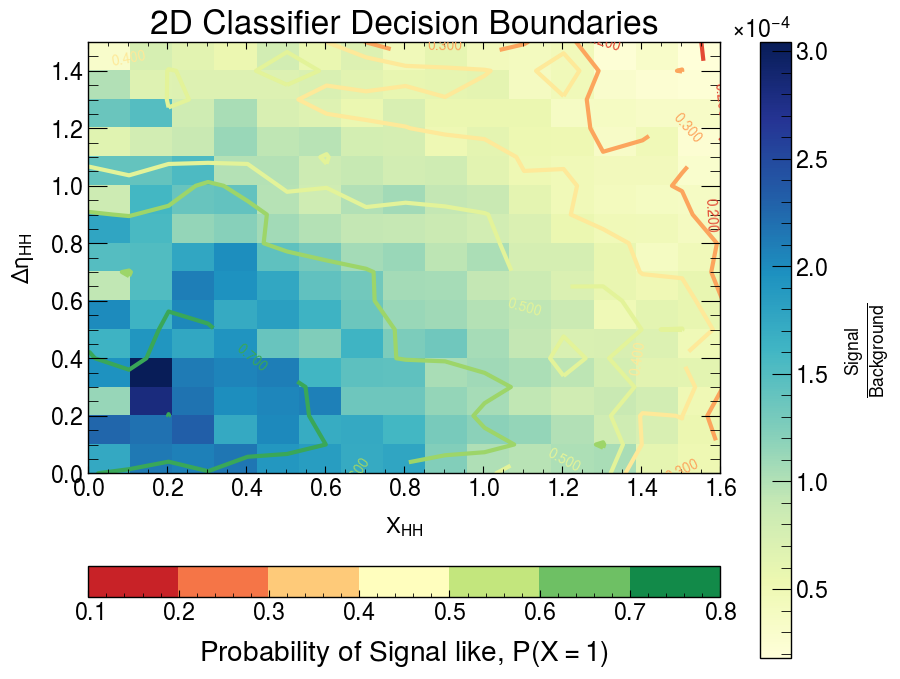

In [220]:
f, ax = plt.subplots(figsize=(10,8))
cs = ax.contourf(xx, yy, zzp, cmap="RdYlGn", linewidths=3, zorder=0)
_ = hist2d_ratio(
    soverb,
    ax=ax,
    xedges=xedges,
    yedges=yedges,
    xlabel=r"$X_{HH}$",
    ylabel=r"$\Delta\eta_{HH}$",
    colorbar=True,
    colorbarlabel=r'$\frac{Signal}{Background}$'
)
cont = ax.contour(xx, yy, zzp, cmap="RdYlGn", linewidths=3)
ax.clabel(cont, inline=True, fontsize=10)
cbar = plt.colorbar(cs,orientation='horizontal')
cbar.set_label('Probability of Signal like, $P(X=1)$')
# plt.colorbar(cs, cax=ax)
# cs = ax.contour(X1, X2, y_prob, [0.6,0.75], colors ='green')
ax.set_xlim(0, 1.6)
ax.set_ylim(0, 1.5)
ax.set_title('2D Classifier Decision Boundaries')


# Nominal Category

Text(0.5, 1.0, '4 Quadrant decision boundaries')

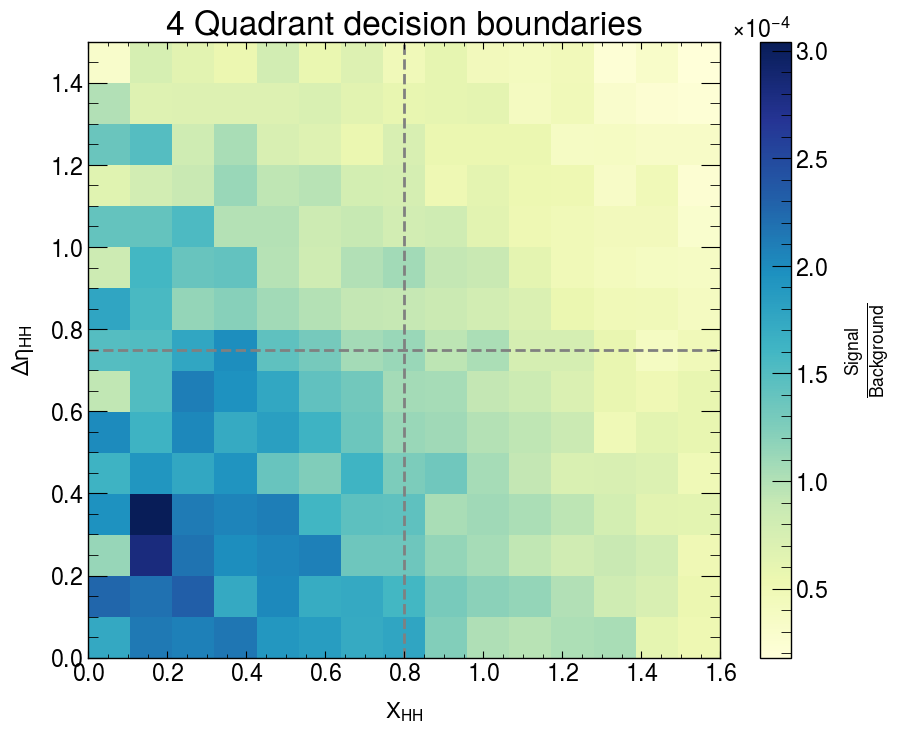

In [268]:
f, ax = plt.subplots(figsize=(10,8))
#cs = ax.contourf(xx, yy, zzp, cmap="RdYlGn", linewidths=3, zorder=0)
_ = hist2d_ratio(
    soverb,
    ax=ax,
    xedges=xedges,
    yedges=yedges,
    xlabel=r"$X_{HH}$",
    ylabel=r"$\Delta\eta_{HH}$",
    colorbar=True,
    colorbarlabel=r'$\frac{Signal}{Background}$'
)
ax.axvline(0.8,ls='--',color='grey')
ax.axhline(0.75,ls='--',color='grey')
# cont = ax.contour(xx, yy, zzp, cmap="RdYlGn", linewidths=3)
# ax.clabel(cont, inline=True, fontsize=10)
# cbar = plt.colorbar(cs,orientation='horizontal')
# cbar.set_label('Probability of Signal like, $P(X=1)$')
# plt.colorbar(cs, cax=ax)
# cs = ax.contour(X1, X2, y_prob, [0.6,0.75], colors ='green')
ax.set_xlim(0, 1.6)
ax.set_ylim(0, 1.5)
ax.set_title('4 Quadrant decision boundaries')


# Xhh Comb categories

In [222]:
def xcomb(xhh, deta_hh):
    return np.sqrt((deta_hh/1.5)**2 + (xhh)**2)

In [269]:
f, ax = plt.subplots(figsize=(10,8))
#cs = ax.contourf(xx, yy, zzp, cmap="RdYlGn", linewidths=3, zorder=0)
_ = hist2d_ratio(
    soverb,
    ax=ax,
    xedges=xedges,
    yedges=yedges,
    xlabel=r"$X_{HH}$",
    ylabel=r"$\Delta\eta_{HH}$",
    colorbar=True,
    colorbarlabel=r'$\frac{Signal}{Background}$'
)
ax.axvline(0.8,ls='--',color='grey')
ax.axhline(0.75,ls='--',color='grey')
cont = ax.contour(xx, yy, xcomb(xx,yy), [0.3, 0.6, 1], cmap="RdYlGn", linewidths=3)
ax.clabel(cont, inline=True, fontsize=10)
# cbar = plt.colorbar(cs,orientation='horizontal')
# cbar.set_label('Probability of Signal like, $P(X=1)$')
# plt.colorbar(cs, cax=ax)
# cs = ax.contour(X1, X2, y_prob, [0.6,0.75], colors ='green')
ax.set_xlim(0, 1.6)
ax.set_ylim(0, 1.5)
ax.set_title('$X_{comb}$ Decision Boundaries')


Text(0.5, 1.0, '$X_{comb}$ Decision Boundaries')

In [243]:
np.linspace(0,1,5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

### Preparing 2D Classifier categories 

In [245]:
pred_data = model2D.predict_proba(data[['Xhh','dEta_hh']].values)

In [249]:
data['XGB_2D'] = pred_data[:,1]

In [250]:
data.loc[data["XGB_2D"] <= 0.25, "XGB_2D_cat"] = 1
data.loc[(data["XGB_2D"] > 0.25) & (data["XGB_2D"] <= 0.5), "XGB_2D_cat"] = 2
data.loc[(data["XGB_2D"] > 0.5) & (data["XGB_2D"] <= 0.75), "XGB_2D_cat"] = 3
data.loc[data["XGB_2D"] > 0.75, "XGB_2D_cat"] = 4

In [251]:
data['XGB_2D_cat'].value_counts()

2.0    204956
3.0    156326
1.0     30022
4.0      2603
Name: XGB_2D_cat, dtype: int64

In [253]:
pred_sig = model2D.predict_proba(df[["Xhh", "dEta_hh"]].values)

In [254]:
df['XGB_2D'] = pred_sig[:,1]

In [255]:
df.loc[df["XGB_2D"] <= 0.25, "XGB_2D_cat"] = 1
df.loc[(df["XGB_2D"] > 0.25) & (df["XGB_2D"] <= 0.5), "XGB_2D_cat"] = 2
df.loc[(df["XGB_2D"] > 0.5) & (df["XGB_2D"] <= 0.75), "XGB_2D_cat"] = 3
df.loc[df["XGB_2D"] > 0.75, "XGB_2D_cat"] = 4

# Preparing Quadrant Categories

In [258]:
plt.axvline(0.8)
plt.axhline(0.75)
plt.xlim(0, 1.6)
plt.ylim(0,1.5)

(0.0, 1.5)

In [259]:
Q1_mask = (data['Xhh'] > 0.8) & (data['dEta_hh'] > 0.75)
Q2_mask = (data['Xhh'] <= 0.8) & (data['dEta_hh']> 0.75)
Q3_mask = (data['Xhh'] <= 0.8) & (data['dEta_hh'] < 0.75)
Q4_mask = (data['Xhh']> 0.8) & (data['dEta_hh'] < 0.75)

In [260]:
data.loc[Q1_mask, 'Q_xd'] = 1
data.loc[Q2_mask, 'Q_xd'] = 2
data.loc[Q3_mask, 'Q_xd'] = 3
data.loc[Q4_mask, 'Q_xd'] = 4

In [261]:
Q1_mask = (df['Xhh'] > 0.8) & (df['dEta_hh'] > 0.75)
Q2_mask = (df['Xhh'] <= 0.8) & (df['dEta_hh']> 0.75)
Q3_mask = (df['Xhh'] <= 0.8) & (df['dEta_hh'] < 0.75)
Q4_mask = (df['Xhh']> 0.8) & (df['dEta_hh'] < 0.75)

In [262]:
df.loc[Q1_mask, 'Q_xd'] = 1
df.loc[Q2_mask, 'Q_xd'] = 2
df.loc[Q3_mask, 'Q_xd'] = 3
df.loc[Q4_mask, 'Q_xd'] = 4

### Preparing Xcomb categories

In [232]:
data['Xcomb'] = xcomb(data['Xhh'],data['dEta_hh'])

In [233]:
data['Xcomb_cat'] = 4

In [236]:
mask_cat1 = data['Xcomb'] <= 0.3
mask_cat2 = (data['Xcomb']>0.3 )& (data['Xcomb']<=0.6)
mask_cat3 = (data['Xcomb']>0.6) & (data['Xcomb'] <=1.0)

In [237]:
data.loc[mask_cat1,'Xcomb_cat'] = 1
data.loc[mask_cat2,'Xcomb_cat'] = 2
data.loc[mask_cat3,'Xcomb_cat'] = 3

In [238]:
data['Xcomb_cat'].value_counts()

4    288970
3     81992
2     20024
1      2921
Name: Xcomb_cat, dtype: int64

In [256]:
df['Xcomb'] = xcomb(df['Xhh'], df['dEta_hh'])
df['Xcomb_cat'] = 4
mask_cat1 = df['Xcomb'] <= 0.3
mask_cat2 = (df['Xcomb']>0.3 )& (df['Xcomb']<=0.6)
mask_cat3 = (df['Xcomb']>0.6) & (df['Xcomb'] <=1.0)
df.loc[mask_cat1,'Xcomb_cat'] = 1
df.loc[mask_cat2,'Xcomb_cat'] = 2
df.loc[mask_cat3,'Xcomb_cat'] = 3

In [240]:
from hh4b_utils.nnt_tools import convert_dataframe_to_nnt

In [241]:
help(convert_dataframe_to_nnt)

Help on function convert_dataframe_to_nnt in module hh4b_utils.nnt_tools:

convert_dataframe_to_nnt(df:pandas.core.frame.DataFrame, out_file_path:str)



In [ ]:
"/mnt/storage/lborgna/NNT/MDR_VEC/data/data_CRVRSR_2B_SRshift_16_NN_100_bootstraps_cats.root"

In [263]:
convert_dataframe_to_nnt(data, "/mnt/storage/lborgna/NNT/MDR_VEC/data/data_CRVRSR_2B_SRshift_16_NN_100_bootstraps_cats.root")

100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


In [ ]:
"/mnt/storage/lborgna/NNT/MDR_VEC/mc/mc16a_2b_shiftKR_lshi_cats.root"

In [264]:
convert_dataframe_to_nnt(df, "/mnt/storage/lborgna/NNT/MDR_VEC/mc/mc16a_2b_shiftKR_lshi_cats.root")

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


In [ ]:
data

### X_comb=sqrt{(dEtaHH/1.5)^2+(Xhh)^2},